Install snnTorch and torchvision:

In [1]:
# Uncomment as necessary
#! pip install snntorch
#! pip install --user --no-deps torchvision

# 1. Setting up the MNIST dataset

## 1.2 Import packages and set up environment

In [2]:
import snntorch as snn
import torch

Set some basic parameters for training a model on the MNIST dataset
- `batch_size`: the number of samples in each batch of data that will be used to train the model
- `data_path`: the path to the directory where the MNIST dataset is stored
- `num_classes`: the number of output classes in the MNIST dataset
- `dtype`: the data type of the Torch variables that will be used in the model

In [3]:
# Training Parameters
batch_size = 128
data_path = '/tmp/data/mnist'
num_classes = 10  # MNIST has 10 output classes

# Torch Variables
dtype = torch.float

## 1.2 Download dataset

Transform the MNIST dataset by:
- Resizing the input images to 28x28 pixels
- Converting them to grayscale
- Converting them to a PyTorch tensor
- Normalising the pixel values to have a mean of 0 and a standard deviation of 1

In [4]:
from torchvision import datasets, transforms

# Define a transform
transform = transforms.Compose([
            transforms.Resize((28,28)),
            transforms.Grayscale(),
            transforms.ToTensor(),
            transforms.Normalize((0,), (1,))])

mnist_train = datasets.MNIST(data_path, train=True, download=True, transform=transform)

Apply `data_subset` from `snntorch.utils` to reduce the dataset by the factor defined in `subset`. E.g., for `subset = 10`, a training set of 60,000 will be reduced to 6,000.

In [5]:
from snntorch import utils

subset = 10
mnist_train = utils.data_subset(mnist_train, subset)

In [6]:
print(f"The size of mnist_train is {len(mnist_train)}")

The size of mnist_train is 6000


## 1.3 Create dataloaders

Create a `DataLoader` object called `train_loader` that loads the `mnist_train` dataset. The `batch_size` parameter specifies the number of samples per batch, and `shuffle = True` specifies that the data should be shuffled before each epoch. 

In [7]:
from torch.utils.data import DataLoader

train_loader = DataLoader(mnist_train, batch_size = batch_size, shuffle = True)

# 2. Spike encoding

## 2.1 Rate coding of MNIST

Create a vector filled with the value ‘0.5’ and encode it using a Bernoulli trial:
$$ P(R_{ij}=1)=X_{ij}=1-P(R_{ij}=0) $$

In [8]:
# Temporal Dynamics
num_steps = 10

# create vector filled with 0.5
raw_vector = torch.ones(num_steps)*0.5

# pass each sample through a Bernoulli trial
rate_coded_vector = torch.bernoulli(raw_vector)

In [9]:
print(f"Converted vector: {rate_coded_vector}")

Converted vector: tensor([1., 0., 0., 0., 0., 1., 0., 0., 1., 1.])


In [10]:
print(f"The output is spiking {rate_coded_vector.sum()*100/len(rate_coded_vector):.2f}% of the time.")

The output is spiking 40.00% of the time.


Now we will try again, but increasing the length of raw_vector:

In [11]:
# Temporal Dynamics
num_steps = 100

# create vector filled with 0.5
raw_vector = torch.ones(num_steps)*0.5

# pass each sample through a Bernoulli trial
rate_coded_vector = torch.bernoulli(raw_vector)

In [12]:
print(f"The output is spiking {rate_coded_vector.sum()*100/len(rate_coded_vector):.2f}% of the time.")

The output is spiking 47.00% of the time.


As `num_steps` $\rightarrow \infty$, the proportion of spikes approaches the original raw value.

For an MNIST image, this probability of spiking corresponds to the pixel value. A white pixel corresponds to a 100% probability of spiking, and a black pixel will never generate a spike. `spikegen.rate` can be used to generate a rate-coded sample of data, and we can use `num_steps` to repeat it across time.

- `data = iter(train_loader)`: Creates an iterator for the `train_loader` data loader object. This object is used to load the training data in batches.
- `data_it, targets_it = next(data)`: Loads the next batch of data and targets from the iterator using the `next()` function. The `data_it` variable contains the input data, and the `targets_it` variable contains the corresponding target labels.
- `spike_data = spikegen.rate(data_it, num_steps=num_steps)`: Generates a rate-coded vector using the `spikegen.rate()` function. This function takes the input data as the first argument and the number of time steps as the second argument. The `num_steps` variable is defined earlier in the code. The output `spike_data` is a PyTorch tensor that contains the rate-coded data.

In [13]:
from snntorch import spikegen

# Iterate through minibatches
data = iter(train_loader)
data_it, targets_it = next(data)

# Spiking Data
spike_data = spikegen.rate(data_it, num_steps = num_steps)

If the input falls outside of [0, 1], this no longer represents a probability. Such cases are automatically clipped to ensure the feature represents a probability.

The structure of the input data is [num_steps x batch_size x input dimensions]:

In [14]:
print(spike_data.size())

torch.Size([100, 128, 1, 28, 28])


## 2.2 Visualisation

### 2.2.1 Animation

In [15]:
import matplotlib.pyplot as plt
import snntorch.spikeplot as splt
from IPython.display import HTML

To plot one sample of data, index into a single sample from the batch (B) dimension of spike_data, [T x B x 1 x 28 x 28]:

In [16]:
spike_data_sample = spike_data[:, 0, 0]
print(spike_data_sample.size())

torch.Size([100, 28, 28])


If you are running the notebook locally on your desktop, please modify the path to your ffmpeg.exe

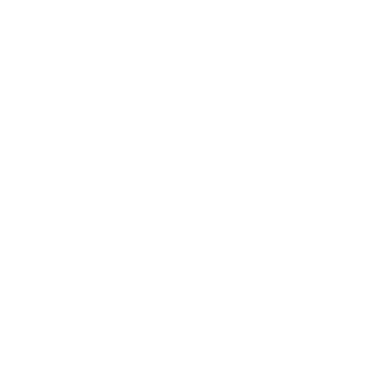

In [17]:
fig, ax = plt.subplots()
anim = splt.animator(spike_data_sample, fig, ax)
plt.rcParams['animation.ffmpeg_path'] = r'C:\\path\\to\\your\\ffmpeg.exe'

HTML(anim.to_html5_video())

In [18]:
# Save the animation as mp4
anim.save("spike_mnist_test.mp4")

The associated target label can be indexed as follows:

In [19]:
print(f"The corresponding target is: {targets_it[0]}")

The corresponding target is: 8


MNIST features a greyscale image, and the white text guarantees a 100% of spiking at every time step. Let’s do that again but reduce the spiking frequency. This can be achieved by setting the argument gain. Here, we will reduce spiking frequency to 25%.

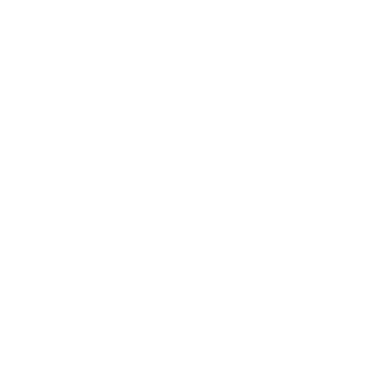

In [20]:
spike_data = spikegen.rate(data_it, num_steps=num_steps, gain=0.25)

spike_data_sample2 = spike_data[:, 0, 0]
fig, ax = plt.subplots()
anim = splt.animator(spike_data_sample2, fig, ax)
HTML(anim.to_html5_video())

In [21]:
# Save the animation as mp4
anim.save("spike_mnist_test2.mp4")

Now average the spikes out over time and reconstruct the input images.

plt.figure(facecolor="w")
plt.subplot(1,2,1)
plt.imshow(spike_data_sample.mean(axis=0).reshape((28,-1)).cpu(), cmap='binary')
plt.axis('off')
plt.title('Gain = 1')

plt.subplot(1,2,2)
plt.imshow(spike_data_sample2.mean(axis=0).reshape((28,-1)).cpu(), cmap='binary')
plt.axis('off')
plt.title('Gain = 0.25')

plt.show()

The case where gain = 0.25 is lighter than where gain = 1, as spiking probability has been reduced by a factor of $\times 4$.

### 2.2.2 Raster Plots

Alternatively, we can generate a raster plot of an input sample. This requires reshaping the sample into a 2-D tensor, where ‘time’ is the first dimension. Pass this sample into the function `spikeplot.raster`.

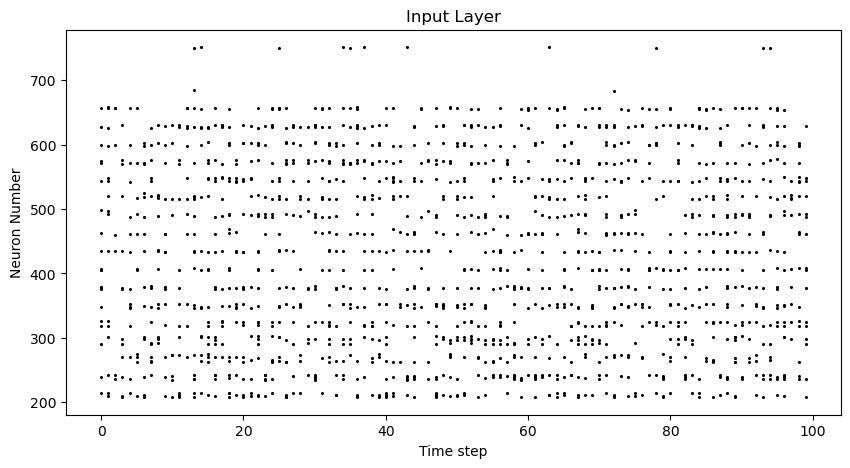

In [22]:
# Reshape
spike_data_sample2 = spike_data_sample2.reshape((num_steps, -1))

# raster plot
fig = plt.figure(facecolor = "w", figsize = (10, 5))
ax = fig.add_subplot(111)
splt.raster(spike_data_sample2, ax, s = 1.5, c = "black")

plt.title("Input Layer")
plt.xlabel("Time step")
plt.ylabel("Neuron Number")
plt.show()

We will also index into one single neuron. Depending on the input data, you may need to try a few different neurons between 0 & 784 before finding one that spikes.

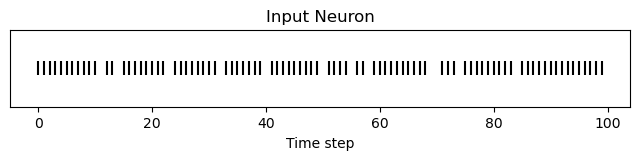

In [23]:
idx = 240  # index into 240th neuron

fig = plt.figure(facecolor="w", figsize=(8, 1))
ax = fig.add_subplot(111)

splt.raster(spike_data_sample.reshape(num_steps, -1)[:, idx].unsqueeze(1), ax, s=100, c="black", marker="|")

plt.title("Input Neuron")
plt.xlabel("Time step")
plt.yticks([])
plt.show()

# 3. Trying it with CIFAR-100

Now I will try the same process with CIFAR-100 dataset to make sure I understand this.

The differences between MNIST and CIFAR-100 datasets are:
- Image size: MNIST images are 28x28 pixels, while CIFAR-100 images are 32x32 pixels.
- Number of channels: MNIST images are grayscale, while CIFAR-100 images are RGB color images with 3 channels.
- Number of classes: MNIST has 10 output classes, while CIFAR-100 has 100 output classes.
- Data format: MNIST data is stored as a 2D array of pixel values, while CIFAR-100 data is stored as a 3D array of RGB pixel values.
- Dataset size: MNIST has 60,000 training images and 10,000 test images, while CIFAR-100 has 50,000 training images and 10,000 test images.
- Complexity: CIFAR-100 is a more complex dataset than MNIST, as it contains images of 100 different classes, each with more variation in appearance and background.

Set some basic parameters for training a model on the CIFAR-100 dataset
- `batch_size`: the number of samples in each batch of data that will be used to train the model
- `data_path`: the path to the directory where the CIFAR-100t dataset is stored
- `num_classes`: the number of output classes in the CIFAR-100 dataset
- `dtype`: the data type of the Torch variables that will be used in the model

In [24]:
batch_size = 64
data_path = '/tmp/data/cifar-100'
num_classes = 100

# Torch Variables
dtype = torch.float

Transform the CIFAR-100 dataset by:
- Resizing the input images to 32x32 pixels
- Converting them to a tensor
- Normalizing them using the mean and standard deviation of the dataset

In [25]:
transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

cifar100_train = datasets.CIFAR100(data_path, train=True, download=True, transform=transform)

Files already downloaded and verified


Here we will create a list of indices for each class in the training dataset, and select 10% of the indices at random for each class.

In [26]:
import random

# Create a list of indices for each class
class_indices = [[] for _ in range(100)]
for i in range(len(cifar100_train)):
    _, target = cifar100_train[i]
    class_indices[target].append(i)

# Select 10% of the indices for each class
subset_indices = []
for indices in class_indices:
    subset_indices.extend(random.sample(indices, k=int(0.1 * len(indices))))

# Create a subset of the dataset using the selected indices
cifar100_train_subset = torch.utils.data.Subset(cifar100_train, subset_indices)

In [27]:
print(f"The size of mnist_train is {len(cifar100_train_subset)}")

The size of mnist_train is 5000


Create a `DataLoader` object that loads the `cifar100_train_subset` dataset. The `batch_size` parameter specifies the number of samples per batch, and `shuffle = True` specifies that the data should be shuffled before each epoch. 

In [28]:
train_loader = DataLoader(cifar100_train_subset, batch_size = batch_size, shuffle = True)

We will use `spikegen.rate` to generate a rate-coded sample of data, and `num_steps` to repeat it across time.

In [29]:
# Iterate through minibatches
data = iter(train_loader)
data_it, targets_it = next(data)

# Spiking Data
spike_data = spikegen.rate(data_it, num_steps = num_steps)

Check that the structure of the input data is [num_steps x batch_size x input dimensions]:

In [30]:
print(spike_data.size())

torch.Size([100, 64, 3, 32, 32])


To plot one sample of data, index into a single sample from the batch (B) dimension of spike_data, [T x B x 1 x 28 x 28]:

In [31]:
spike_data_sample = spike_data[:, 0, 0]
print(spike_data_sample.size())

torch.Size([100, 32, 32])


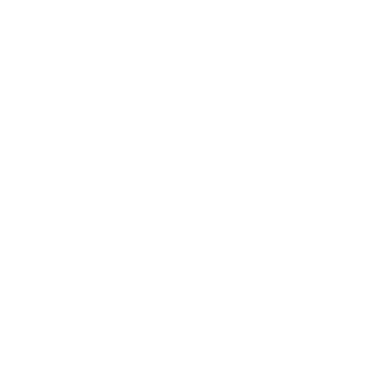

In [32]:
fig, ax = plt.subplots()
anim = splt.animator(spike_data_sample, fig, ax)
HTML(anim.to_html5_video())

In [33]:
# Save the animation as mp4
anim.save("spike_cifar100_test.mp4")

In [34]:
print(f"The corresponding target is: {targets_it[0]}")

The corresponding target is: 0


Reducing the spiking frequency to 25%.

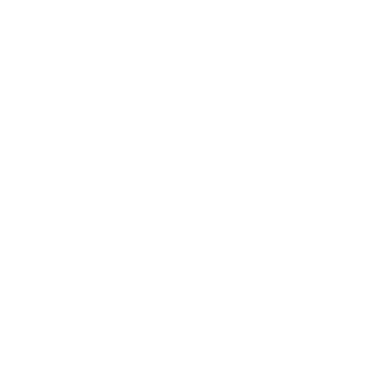

In [35]:
spike_data = spikegen.rate(data_it, num_steps=num_steps, gain=0.25)

spike_data_sample2 = spike_data[:, 0, 0]
fig, ax = plt.subplots()
anim = splt.animator(spike_data_sample2, fig, ax)
HTML(anim.to_html5_video())

In [36]:
# Save the animation as mp4
anim.save("spike_cifar100_test2.mp4")

Generate a raster plot of an input sample.

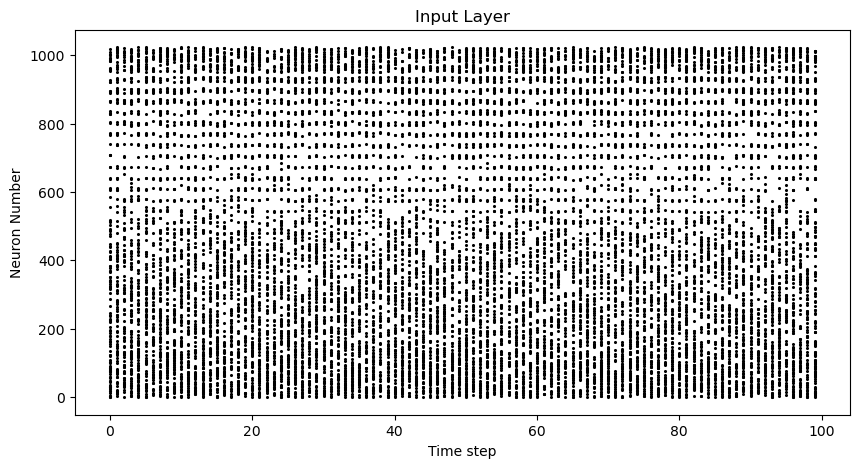

In [37]:
# Reshape
spike_data_sample2 = spike_data_sample2.reshape((num_steps, -1))

# raster plot
fig = plt.figure(facecolor = "w", figsize = (10, 5))
ax = fig.add_subplot(111)
splt.raster(spike_data_sample2, ax, s = 1.5, c = "black")

plt.title("Input Layer")
plt.xlabel("Time step")
plt.ylabel("Neuron Number")
plt.show()

Visualise one single neuron.

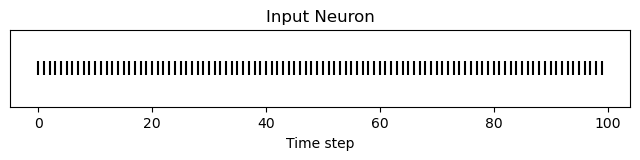

In [38]:
idx = 0  # index into 0th neuron

fig = plt.figure(facecolor="w", figsize=(8, 1))
ax = fig.add_subplot(111)

splt.raster(spike_data_sample.reshape(num_steps, -1)[:, idx].unsqueeze(1), ax, s=100, c="black", marker="|")

plt.title("Input Neuron")
plt.xlabel("Time step")
plt.yticks([])
plt.show()

We can see that the output of CIFAR-100 is be harder to recognize compared to MNIST, because CIFAR-100 contains more complex images with more variation in appearance and background. The images in CIFAR-100 are also larger and contain more color channels than the images in MNIST, which can make them more difficult to process and analyze.